# <u> DSCI 100 Group 16 Project Proposal<u>

### Superstore Marketing Campaign Dataset

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   0.3.4
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

## <u> Introduction<u>

The marketing budgets for companies are skyrocketing these days, but looking at the depression coming in companies are cutting down on the marketing budgets and are finding much more better and economical ways to market their product.

Through this project we aim to predict “will an existing customer at the Superstore will be giving a positive response to their new gold membership offer which gives them 20% off for \\$499 which is \\$999 on regular days?”

The dataset used will list the data collected on birth year, marital status, education level, income, etc. However for this project the main focus will be on the columns marital status, income, number of children, age, total spent, and time as customer.


## <u> Preliminary Exploratory Data Analysis<u>

### Creating a usable data set

The dataset we are going to use comes from Kaggle: https://www.kaggle.com/datasets/ahsan81/superstore-marketing-campaign-dataset.

This data is already in tidy format because each row represented an observation, each column contained a single variable, and each cell contained a single value. 

We made the data set a bit more usable by:
- removing all the rows with 'NA'
- removing discrete variables (Id, Education, Complain)
- combining the Kidhome and Teenhome columns into a Childhome column
- combining the amount spent on all the different categories of food into a single Total_Spent column
- using the Year_Birth column to find the customer's age (this data was published at the end of 2022)
- changing the date the customer joined to the number of weeks they've been a customer
- changing the marital status column to relationship/no relationship column (Yes refers to Married or Together)
- changing the response variable to a factor

In [3]:
set.seed(16)
url <- "https://raw.githubusercontent.com/nchan315/DSCI_100_007_16_Project/main/superstore_data.csv"
data <- read_csv(url)

store_data <- data |>
    # removing rows with NA
    na.omit() |>

    # removing discrete variables
    select(-Id, -Education, -Complain) |>

    # summing the number of children
    mutate(Childhome = Kidhome + Teenhome) |>
    select(-Kidhome, -Teenhome) |>

    # creating an age column
    mutate(Age = 2022 - Year_Birth) |>
    select(-Year_Birth) |>

    # combining the amount spent on food
    mutate(Total_Spent = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts) |>
    select(-MntWines, -MntFruits, -MntMeatProducts, -MntFishProducts, -MntSweetProducts) |>

    # calculating weeks that the customer has been a customer
    mutate(Dt_Customer = as.Date(Dt_Customer, "%m/%d/%Y")) |>
    mutate(Weeks_Customer = difftime("2022-12-31", Dt_Customer, units = "weeks")) |>
    mutate(Weeks_Customer = as.numeric(Weeks_Customer)) |>
    select(-Dt_Customer) |>

    # changing martial status into 2 distinctions
    mutate(Relationship = case_when(Marital_Status == 'Married' | Marital_Status == 'Together' ~ 'Yes',
                                    Marital_Status !=  'Married' & Marital_Status != 'Together' ~ 'No')) |>
    select(-Marital_Status) |>
    mutate(Relationship = as.factor(Relationship)) |>

    # changing response to a factor
    mutate(Response = as.factor(Response))
store_data

Rows: 2240 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Education, Marital_Status, Dt_Customer
dbl (19): Id, Year_Birth, Income, Kidhome, Teenhome, Recency, MntWines, MntF...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Income,Recency,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Response,Childhome,Age,Total_Spent,Weeks_Customer,Relationship
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
84835,0,218,1,4,4,6,1,1,0,52,972,445.7143,No
57091,0,37,1,7,3,7,5,1,0,61,540,445.8571,No
67267,0,30,1,3,2,5,2,0,1,64,221,450.5714,Yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
46310,99,14,2,6,1,5,8,0,1,46,295,563.7143,No
65819,99,63,1,5,4,10,3,0,0,44,1320,526.2857,Yes
94871,99,144,1,8,5,4,7,1,2,53,934,572.7143,Yes


### Exploring the data
Our dataset has 14 variables, but we will not use all of them in our analysis.
We would like to focus on the variables: Relationship, Income, Age, Childhome, Total_Spent, and Weeks_Customer.

In [4]:
store_data_reduced <- store_data |>
    select(Relationship, Income, Age, Childhome, Total_Spent, Weeks_Customer, Response)
glimpse(store_data_reduced)

Rows: 2,216
Columns: 7
$ Relationship   <fct> No, No, Yes, Yes, No, No, Yes, Yes, Yes, Yes, Yes, Yes,…
$ Income         <dbl> 84835, 57091, 67267, 32474, 21474, 71691, 63564, 44931,…
$ Age            <dbl> 52, 61, 64, 55, 33, 64, 68, 55, 68, 68, 75, 43, 63, 41,…
$ Childhome      <dbl> 0, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 2, 2, 1, 1…
$ Total_Spent    <dbl> 972, 540, 221, 11, 57, 1149, 1150, 89, 539, 539, 1182, …
$ Weeks_Customer <dbl> 445.7143, 445.8571, 450.5714, 425.4286, 438.7143, 458.7…
$ Response       <fct> 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0…


We then split our data into a 75% training and 25% testing set based on the response variable.

In [5]:
store_data_split <- initial_split(store_data_reduced, prop = 0.75, strata = Response)
store_data_train <- training(store_data_split) 
store_data_test <- testing(store_data_split)
glimpse(store_data_train)
glimpse(store_data_test)

Rows: 1,661
Columns: 7
$ Relationship   <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, No, No, No…
$ Income         <dbl> 67267, 32474, 44931, 65324, 65324, 81044, 26872, 4428, …
$ Age            <dbl> 64, 55, 55, 68, 68, 75, 41, 53, 45, 64, 62, 64, 68, 56,…
$ Childhome      <dbl> 1, 2, 1, 1, 1, 0, 0, 1, 2, 1, 1, 3, 1, 1, 1, 1, 2, 2, 2…
$ Total_Spent    <dbl> 221, 11, 89, 539, 539, 1182, 40, 38, 152, 20, 62, 8, 30…
$ Weeks_Customer <dbl> 450.5714, 425.4286, 467.0000, 426.0000, 426.0000, 470.1…
$ Response       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
Rows: 555
Columns: 7
$ Relationship   <fct> Yes, Yes, Yes, Yes, Yes, No, No, Yes, Yes, No, Yes, Yes…
$ Income         <dbl> 63564, 62499, 40662, 49544, 61314, 81698, 25959, 64260,…
$ Age            <dbl> 68, 43, 43, 46, 54, 39, 52, 61, 38, 44, 49, 58, 54, 45,…
$ Childhome      <dbl> 0, 1, 1, 1, 1, 0, 2, 0, 1, 3, 1, 1, 2, 1, 1, 2, 0, 1, 0…
$ Total_Spent    <dbl> 1150, 218, 69, 381, 836, 1059, 30, 1544, 35, 16, 41, 

There are 1661 observations in the training set and 555 observation in the testing set.

In [6]:
# number of grouped by relationship
store_data_train |>
    group_by(Relationship) |>
    summarize(count = n())

Relationship,count
<fct>,<int>
No,581
Yes,1080


From the training set, 581 are single and 1080 are not single.

In [7]:
# number of people grouped by response
store_data_train |>
    group_by(Response) |>
    summarize(
        count = n(),
        percentage = n() / 1661 * 100)

Response,count,percentage
<fct>,<int>,<dbl>
0,1412,85.00903
1,249,14.99097


We see that about 15% of people gave a positive response to the promotion.

In [15]:
# single customers grouped by response
single_response <- store_data_train |>
    filter(Relationship == 'No') |>
    group_by(Response) |>
    summarize(
        count = n(),
        percentage = n() / 581 * 100)
single_response

# couples grouped by response
couple_response <- store_data_train |>
    filter(Relationship == 'Yes') |>
    group_by(Response) |>
    summarize(
        count = n(),
        percentage = n() / 1080 * 100)
couple_response


Response,count,percentage
<fct>,<int>,<dbl>
0,454,78.14114
1,127,21.85886


Response,count,percentage
<fct>,<int>,<dbl>
0,958,88.7037
1,122,11.2963


Approximately 21.9% of single people are in favour of the promotion while 11.3% of partners are in favour of the promotion.

In [9]:
store_data_train |>
    group_by(Relationship, Response) |>
    summarize(Avg_age = mean(Age), Avg_child = mean(Childhome), Avg_Income = mean(Income),
              Avg_spent = mean(Total_Spent), Avg_Customer = mean(Weeks_Customer))

`summarise()` has grouped output by 'Relationship'. You can override using the
`.groups` argument.


Relationship,Response,Avg_age,Avg_child,Avg_Income,Avg_spent,Avg_Customer
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
No,0,53.30396,1.0110132,49468.10,457.6101,490.0629
No,1,52.34646,0.6062992,59510.13,875.7402,507.4049
Yes,0,52.99791,0.9801670,52032.86,518.3894,492.0834
Yes,1,51.57377,0.7131148,58827.84,920.5492,511.2869


Shown above are the summary statistics for relationship and response. The single people who gave a positive response have the lowest average number of children and the highest average income. The couples who gave a positive response have the lowest average age and the highest average spending.

Below are the histograms for the five factors:

Warning message:
“Removed 2 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


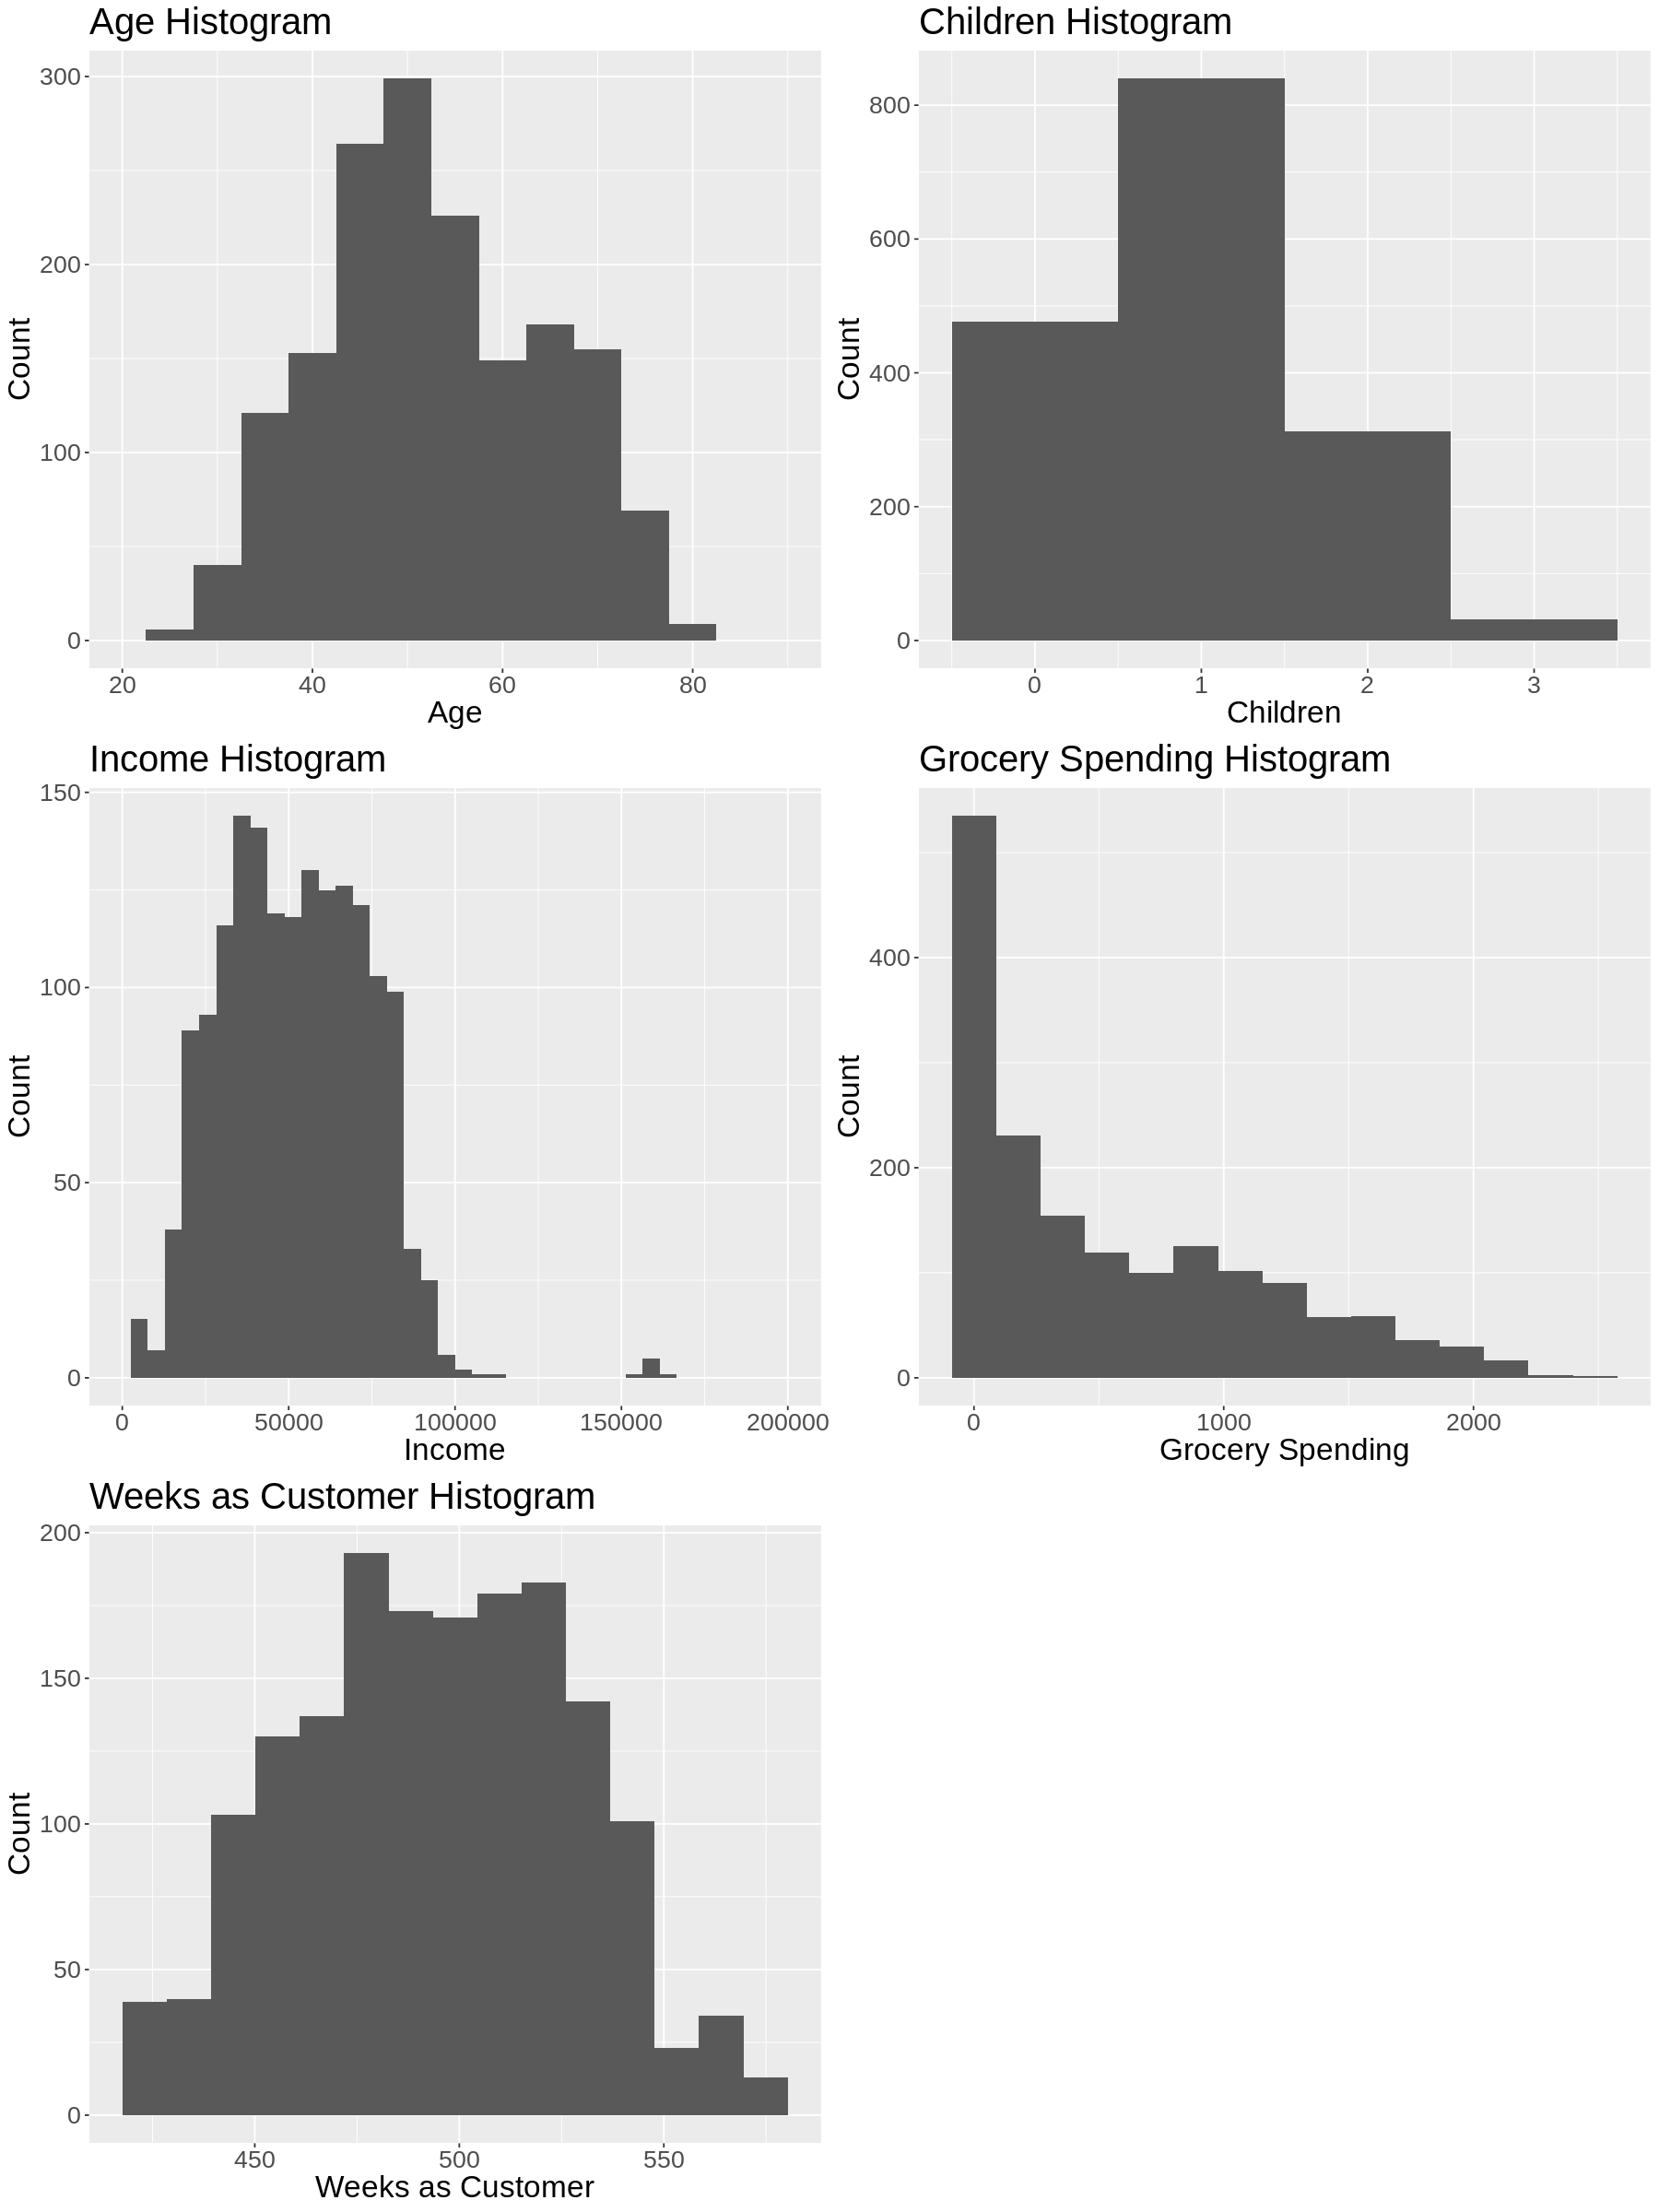

In [10]:
options(repr.plot.width = 15, repr.plot.height = 20)

# age histogram
age_hist <- store_data_train |>
    ggplot(aes(x = Age)) +
        geom_histogram(bins = 15) +
        xlim(20, 90) +
        labs(x = "Age", y = "Count") +
        ggtitle("Age Histogram") +
        theme(text = element_text(size = 20))

# child histogram 
child_hist <- store_data_train |>
    ggplot(aes(x = Childhome)) +
        geom_histogram(bins = 4) +
        labs(x = "Children", y = "Count") +
        ggtitle("Children Histogram") +
        theme(text = element_text(size = 20))

# income histogram
income_hist <- store_data_train |>
    ggplot(aes(x = Income)) +
        geom_histogram(bins = 40) +
        xlim(0, 200000) +
        labs(x = "Income", y = "Count") +
        ggtitle("Income Histogram") +
        theme(text = element_text(size = 20))

# spending histogram
spending_hist <- store_data_train |>
    ggplot(aes(x = Total_Spent)) +
        geom_histogram(bins = 15) +
        labs(x = "Grocery Spending", y = "Count") +
        ggtitle("Grocery Spending Histogram") +
        theme(text = element_text(size = 20))

# customer duration histogram
weeks_hist <- store_data_train |>
    ggplot(aes(x = Weeks_Customer)) +
        geom_histogram(bins = 15) +
        labs(x = "Weeks as Customer", y = "Count") +
        ggtitle("Weeks as Customer Histogram") +
        theme(text = element_text(size = 20))

grid.arrange(age_hist, child_hist, income_hist, spending_hist, weeks_hist, ncol = 2)

From the histograms above, we see that age, number of children, and weeks as customer are all approximately normal. Income is also approximately normal, however, 
it has some very large outliers, making it right-skewed. The grocery spending graph is right-skewed.

## <u> Visualizing the data<u>

We will now visualize the effects of each variable on the response of the customer. In the first plot, we can see what percentage of customers would take the deal compared to how much money they spent in the store. We can see as the total amount of money spent increase, a higher percentage of the customers respond well to the deal. We see a similar pattern when we compare the total amount of money spent in the store to the income; a higher percentage of people responded positively when they spent more money in the store.

In the next two charts, we observe that a higher percentage of single people respond to the deal than those who are in a relationship.


Warning message in geom_histogram(aes(colour = Response, shape = Response), bins = 15):
“Ignoring unknown aesthetics: shape”


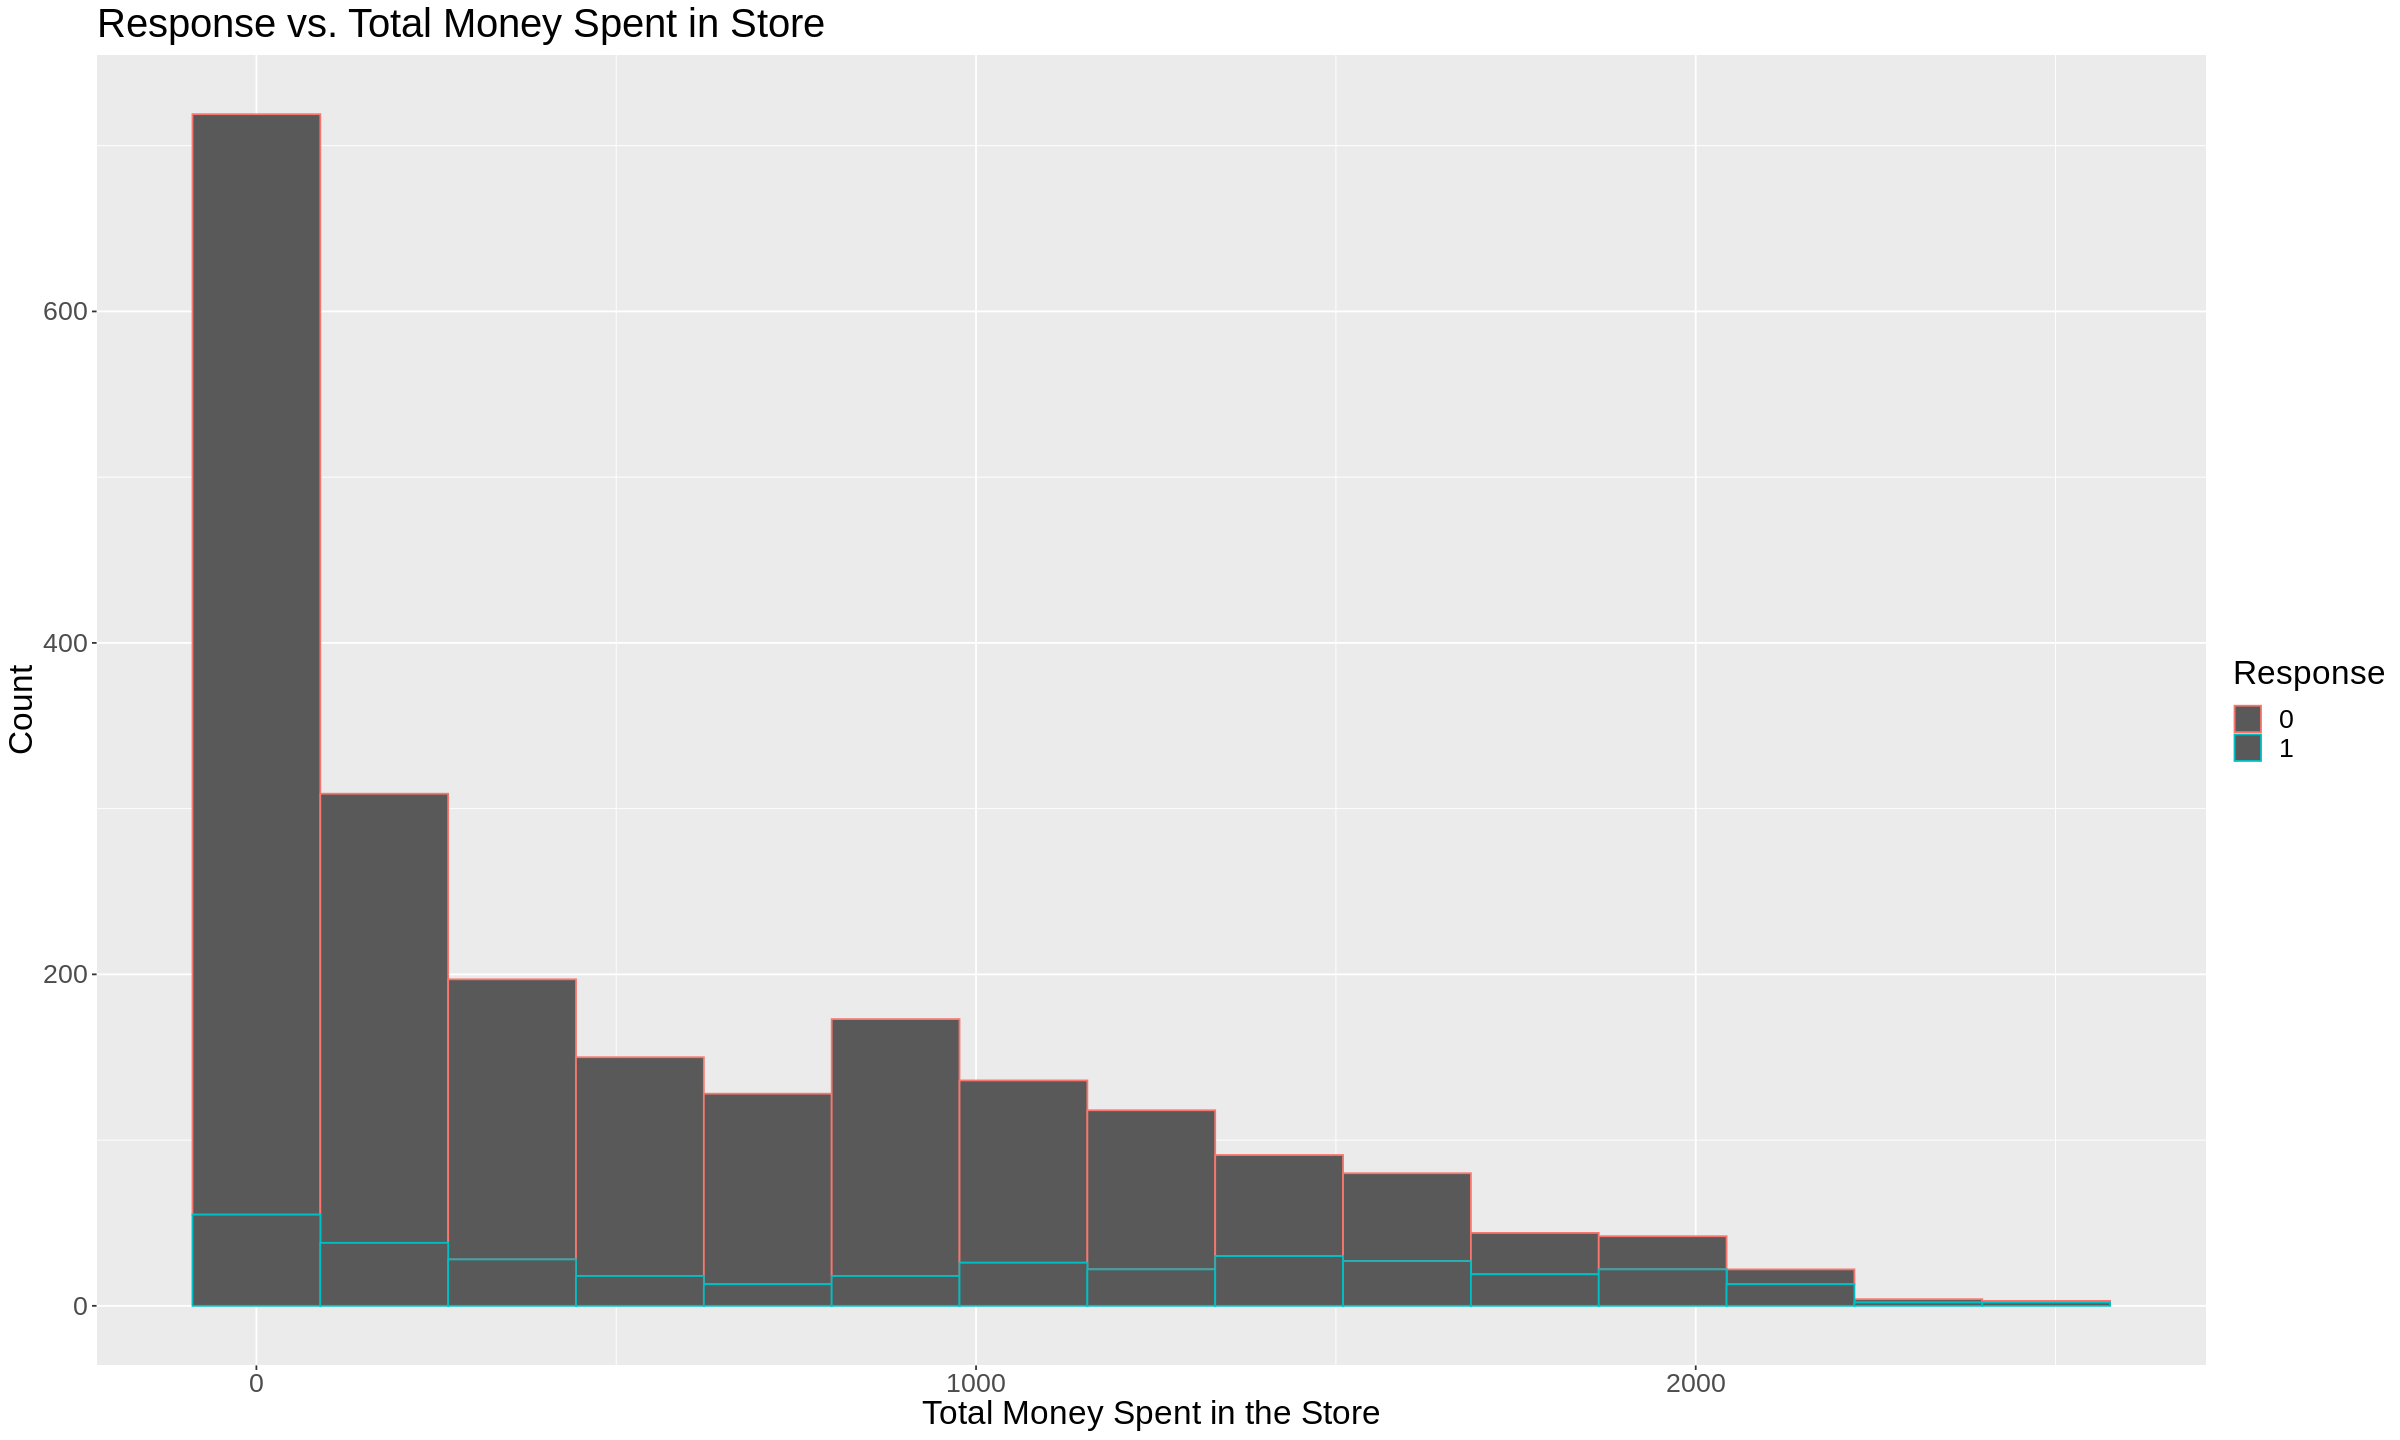

In [11]:
options(repr.plot.width = 20, repr.plot.height = 12)

income_spent <- store_data |>
    ggplot(aes(x=Total_Spent)) +
           geom_histogram(aes(colour = Response, shape = Response), bins = 15) +
            labs(x = "Total Money Spent in the Store", y = "Count", colour = "Response", shape = "Response") +
ggtitle("Response vs. Total Money Spent in Store") +
theme(text = element_text(size = 20))
income_spent

We can see what percentage of customers would take the deal compared to how much money they spent in the store. We can see as the total amount of money spent in the store increases, a higher percentage of the customers respond well to the deal.

Warning message:
“Removed 1 rows containing missing values (`geom_point()`).”


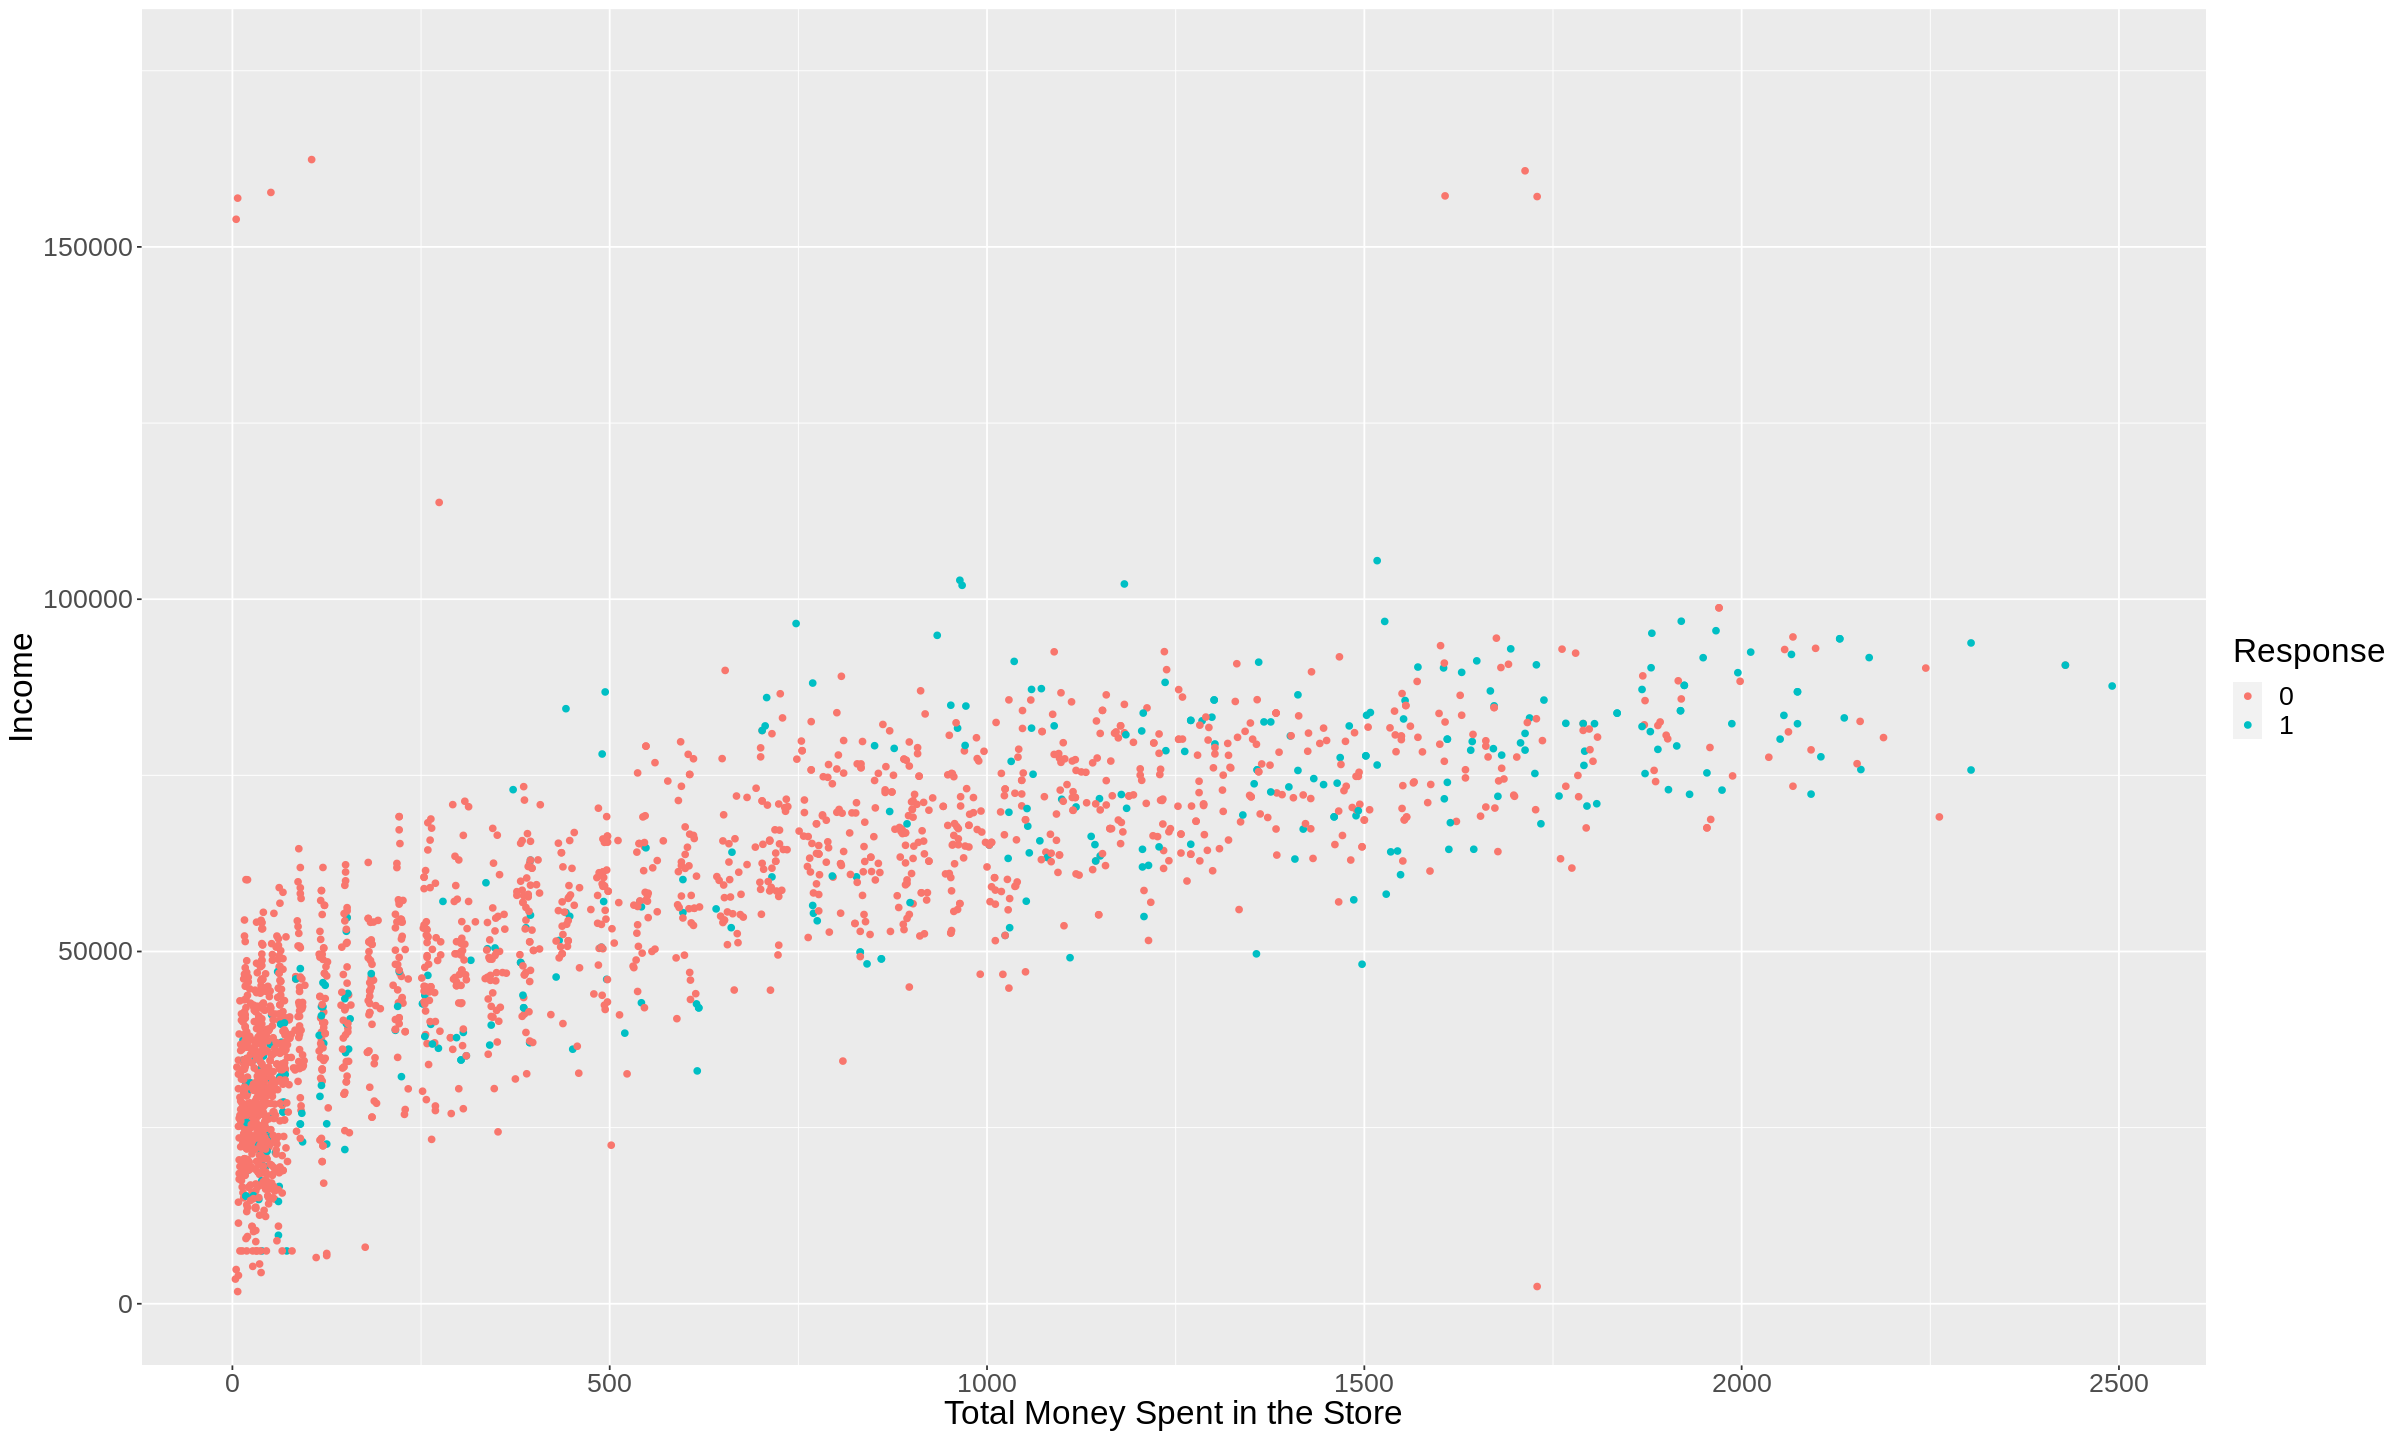

In [12]:
income_vs_totalspent <- store_data |>
    ggplot(aes(x=Total_Spent, y=Income)) +
           geom_point(aes(colour = Response)) +
        ylim(0, 175000) +
            labs(x = "Total Money Spent in the Store", y = "Income", colour = "Response") +
theme(text = element_text(size = 20))
income_vs_totalspent

We see a similar pattern when we compare the total amount of money spent in the store to the income; a higher percentage of people responded positively when they spent more money in the store.

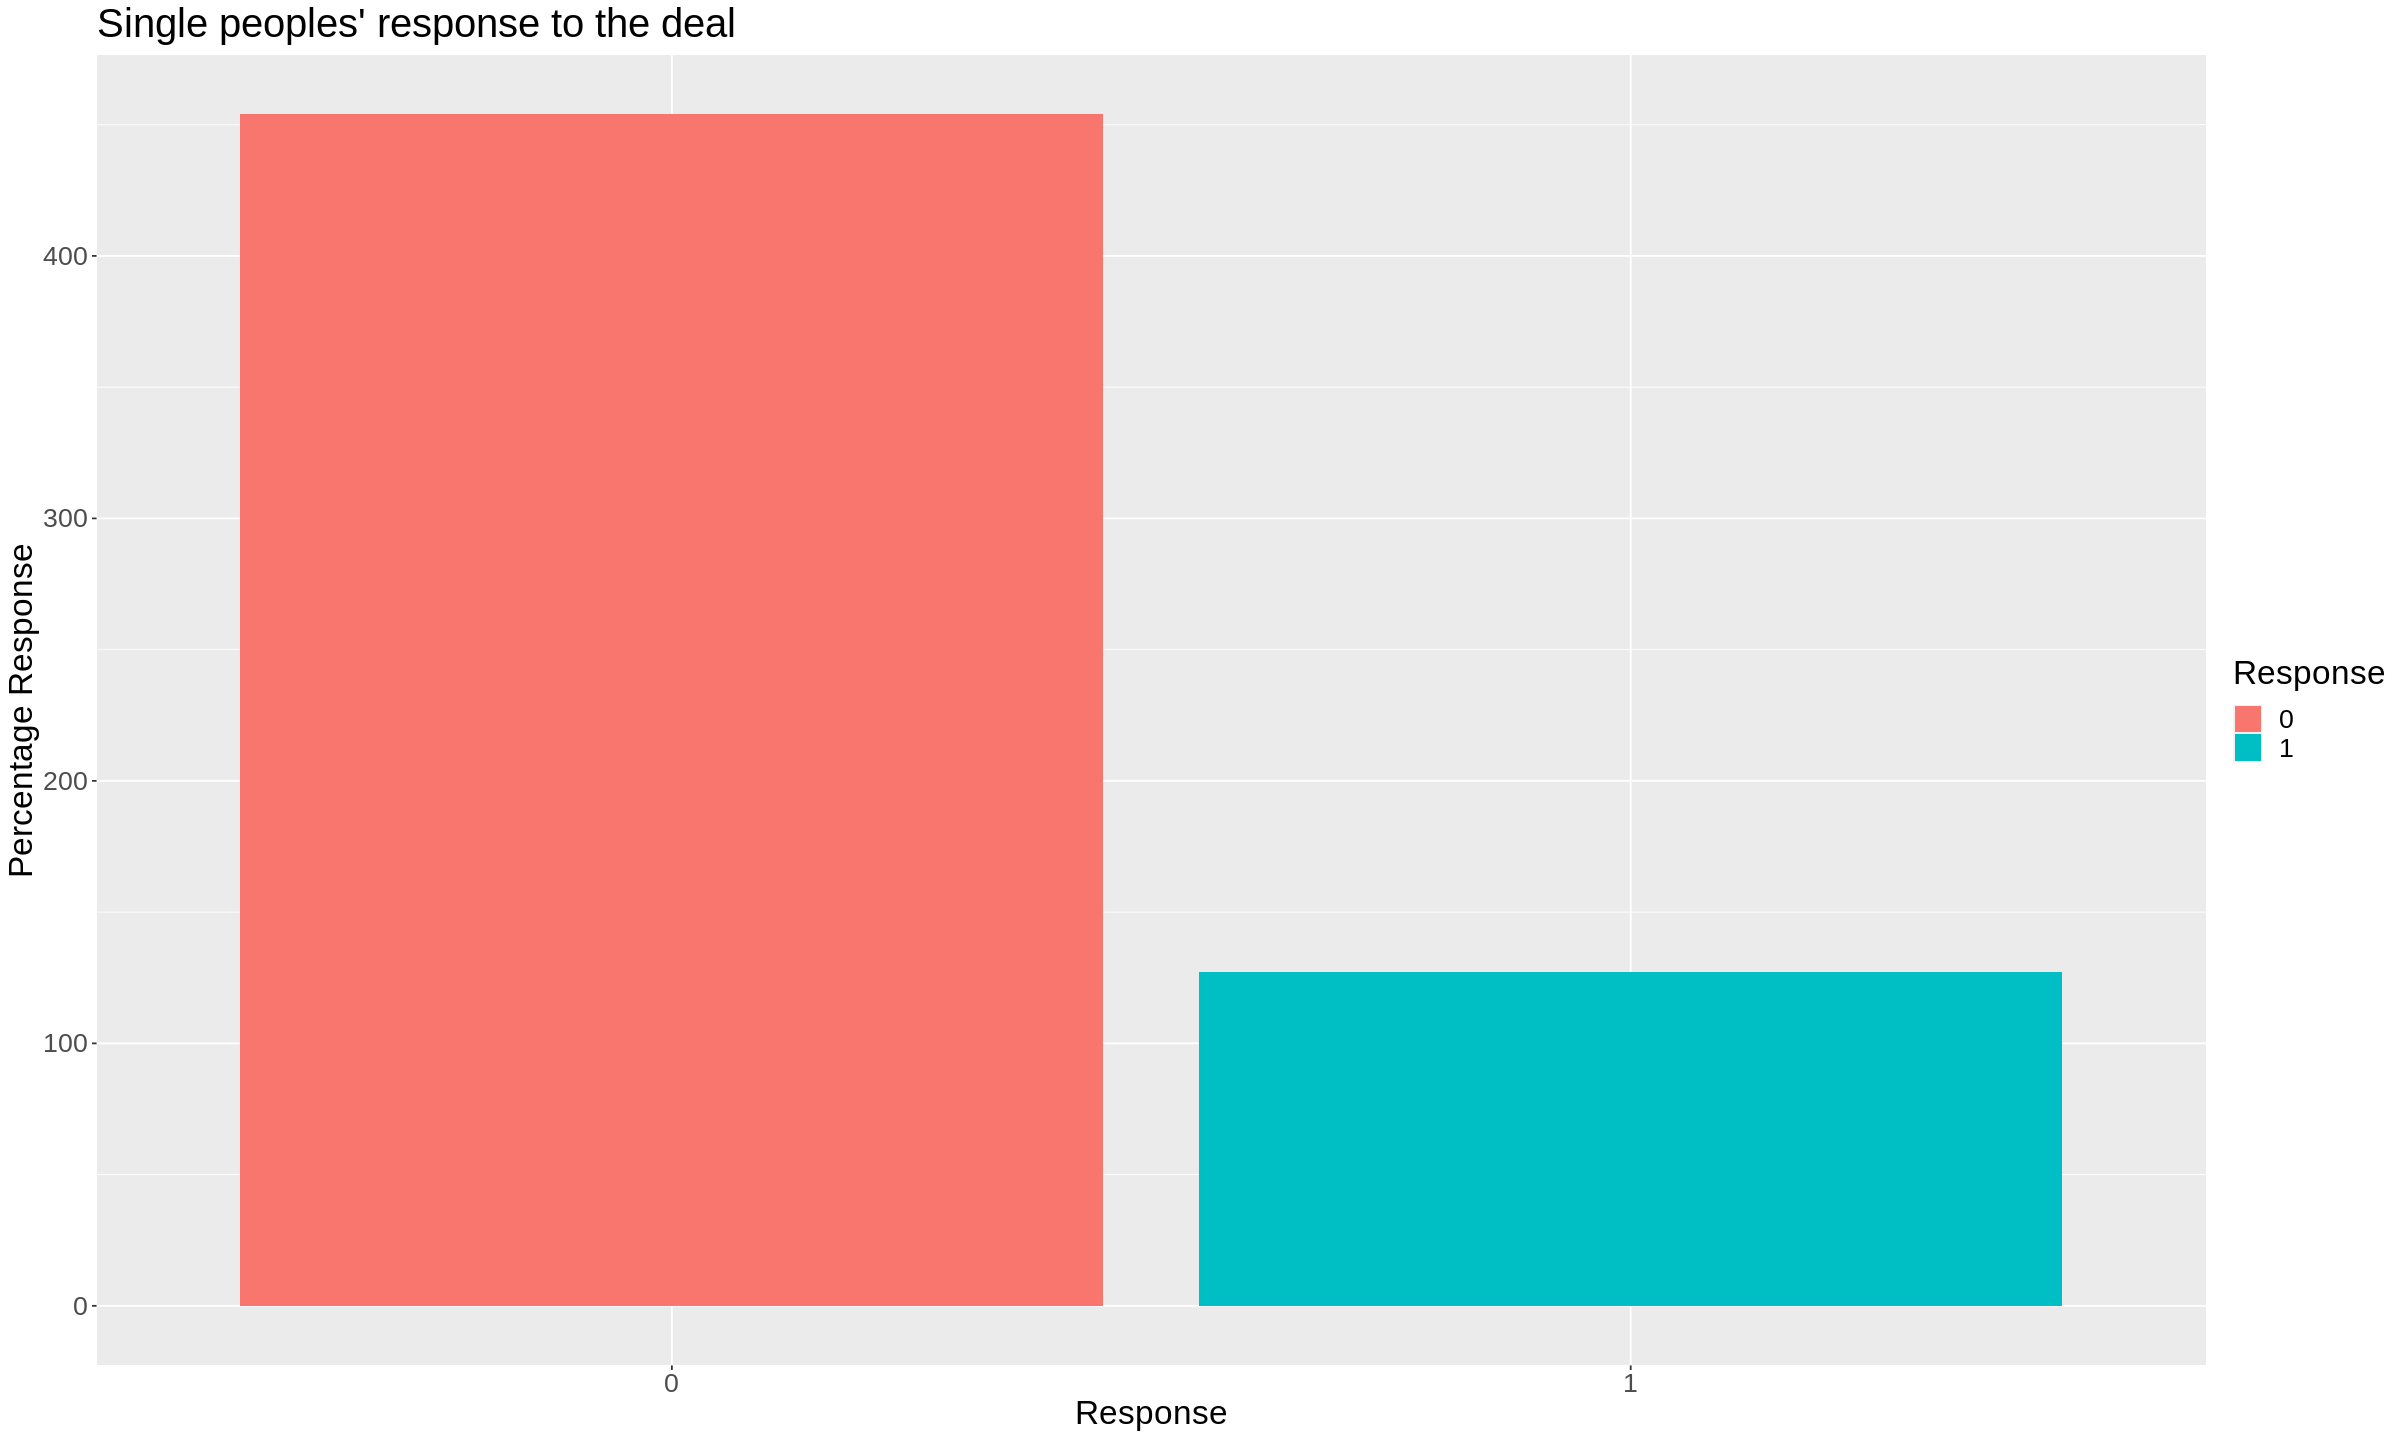

In [13]:
single_plot <- ggplot(single_response, aes(x=Response, y=count, fill=Response)) + 
   geom_bar(stat = "identity") + 
ggtitle("Single peoples' response to the deal") +
  xlab("Response") +
  ylab("Percentage Response") +
theme(text = element_text(size = 20))
single_plot

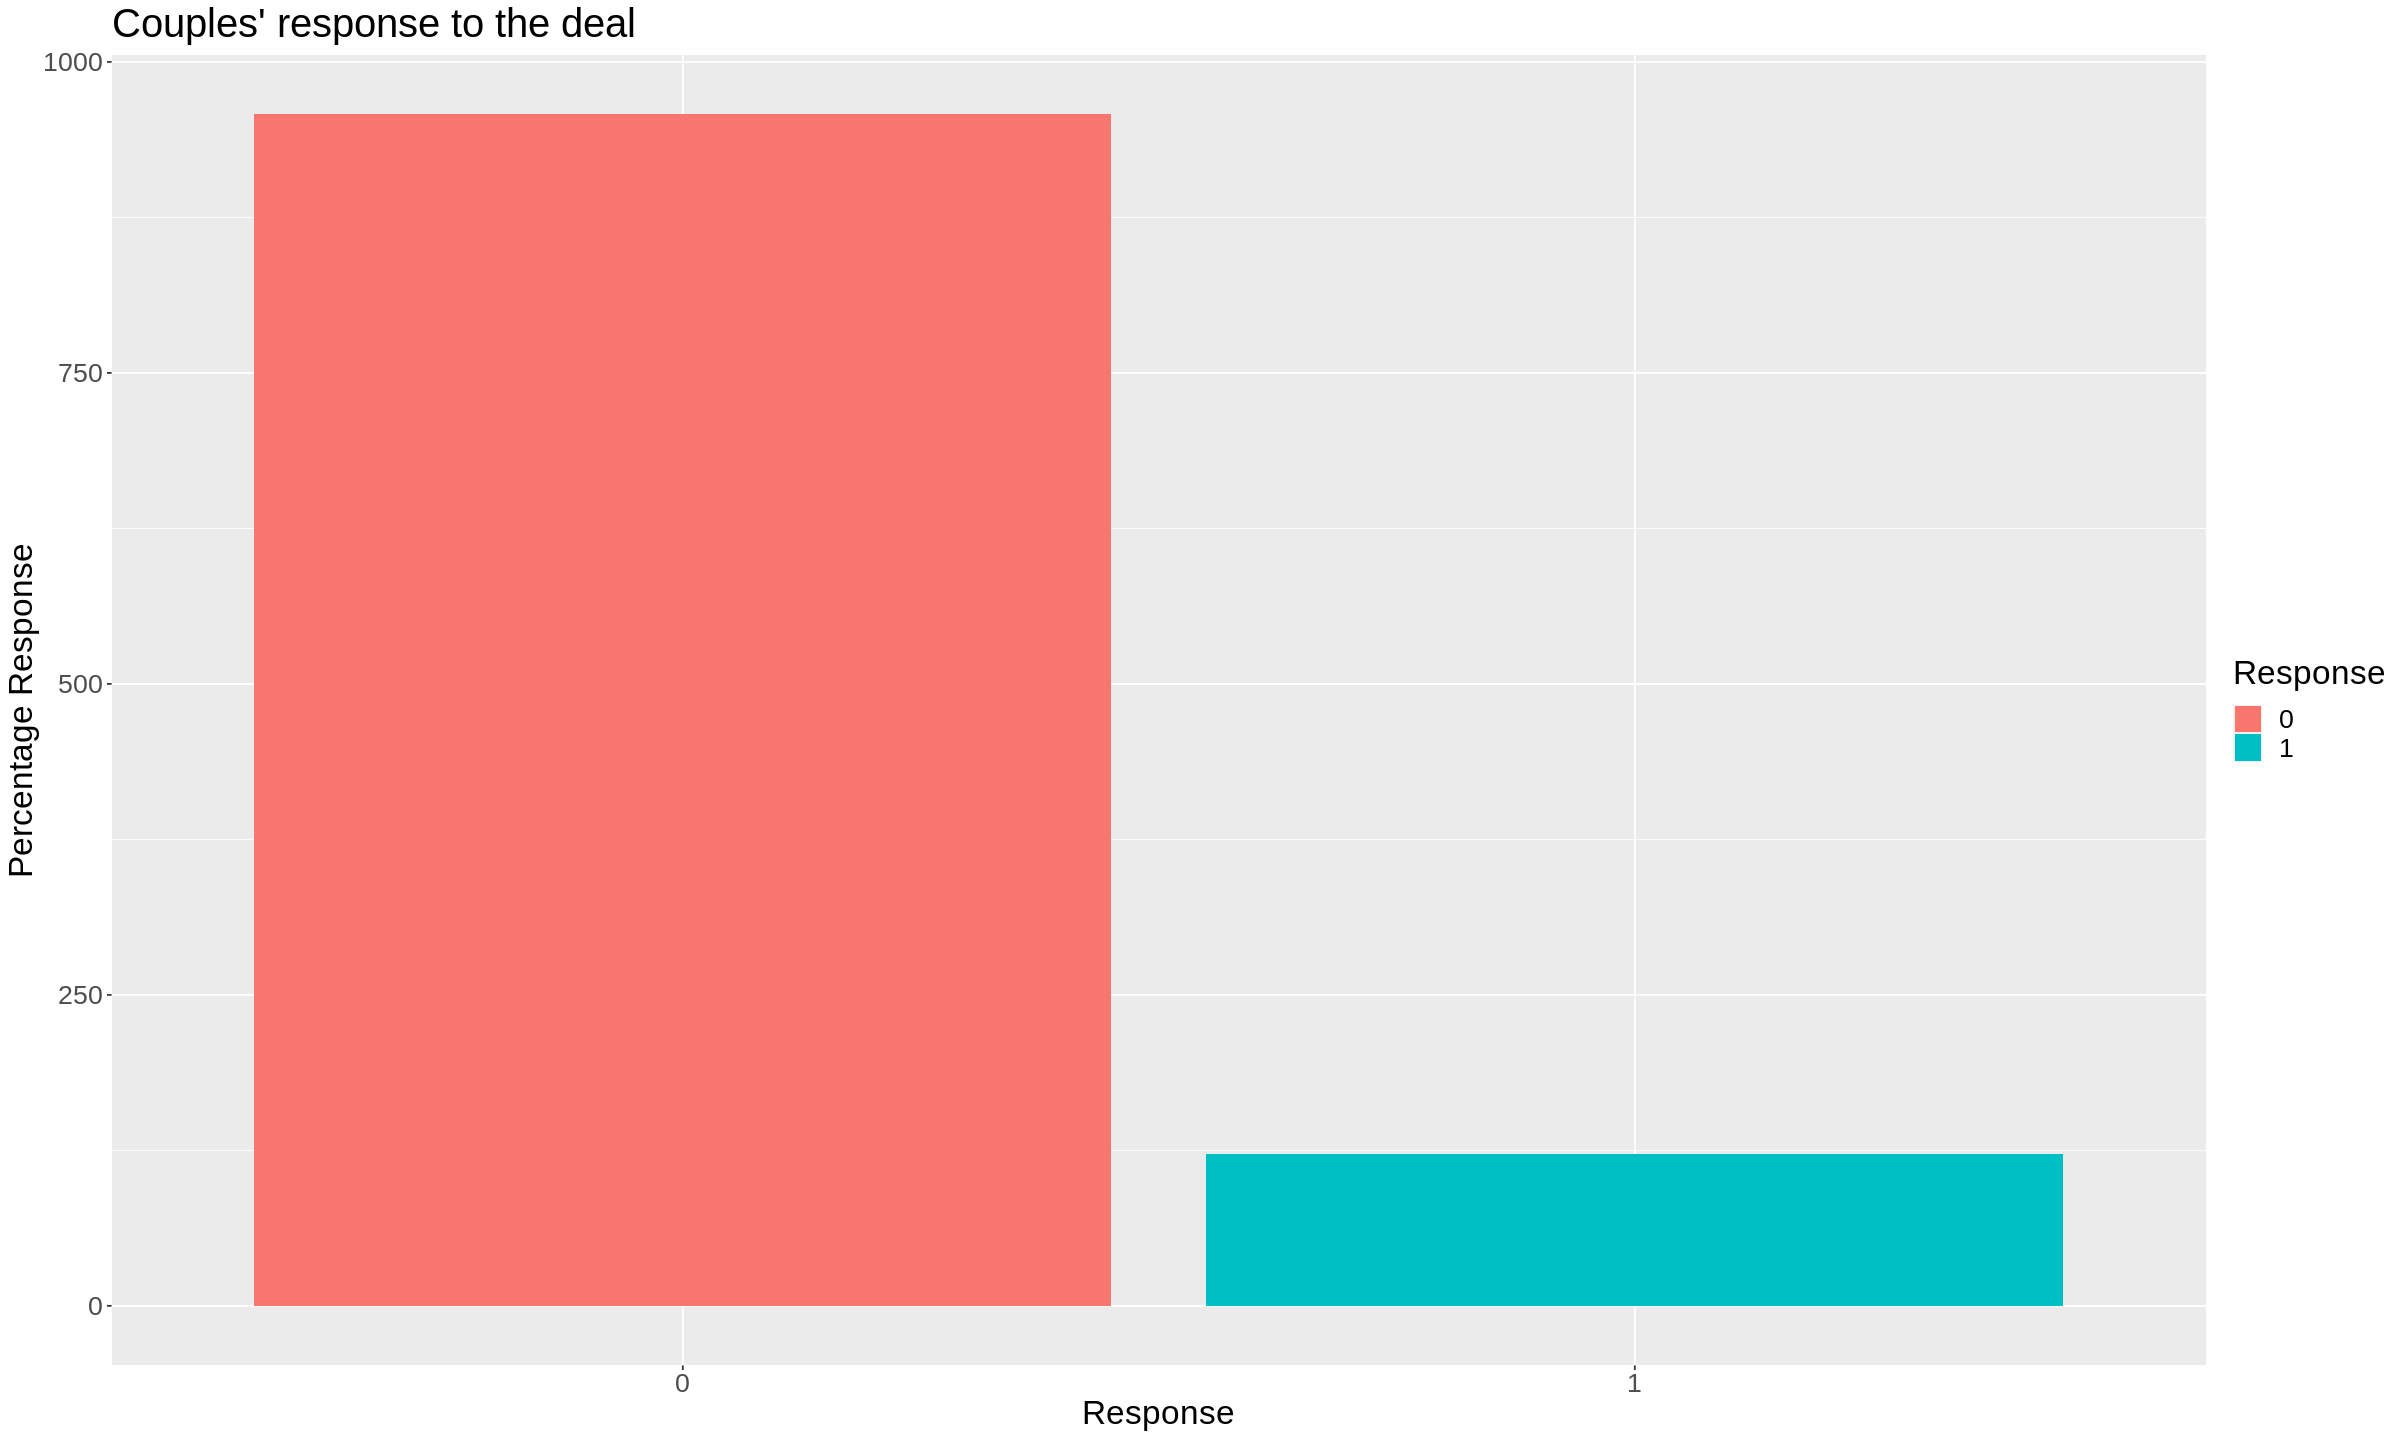

In [14]:
couple_plot <- ggplot(couple_response, aes(x=Response, y=count, fill=Response)) + 
   geom_bar(stat = "identity") + 
    ggtitle("Couples' response to the deal") +
  xlab("Response") +
  ylab("Percentage Response") +
theme(text = element_text(size = 20))
couple_plot

## <u> Methods<u>

We will use the k-nearest neighbours method to create a model that will predict whether a customer will give a positive or negative response to the promotion. We will split the training data into 2 set: in a relationship or not in a relationship. We will then select predictor variables (out of age, income, children, spending, weeks as customer) for the relationship factor using forward selection (6.8.3 in the textbook). We will then choose the K value that gives us the best accuracy. 

We will have a 2 graphs for predictor variable selection (number of predictors vs accuracy) and 2 graphs for K value selection (K value vs accuracy). We hope to visualize the final results in a scatterplot for each relationship type with the desired predictors.

## <u> Expected Outcomes<u>

We predict that people with a higher income and more children are more likely to purchase the gold membership. However, it would be interesting to see whether other factors influence the response. 

By figuring out which groups are more likely to purchase the membership, the Superstore can target this group of people to buy this membership. On the other hand, this leads to other questions: "At what price should we offer this promotion for people to want it more?", or "How can we get people who originally said no to buy this promotion?".